# Text to speech generation

Text To Speech (TTS) models have made great strides in quality over the last few years. Unfortunately, it's not currently possible to use these libraries without installing a large number of dependencies.

The txtai TextToSpeech pipeline has the following objectives:

- Fast performance both on CPU and GPU
- Ability to batch large text values and stream it through the model
- Minimal install footprint
- All dependencies must be Apache 2.0 compatible

This notebook will go through a set of text to speech generation examples.



# Install dependencies

Install `txtai` and all dependencies. Since this notebook is using optional pipelines, we need to install the pipeline extras package. We'll also demonstrate running this pipeline as an application.

In [1]:
%%capture
!pip install git+https://github.com/neuml/txtai#egg=txtai[pipeline] onnxruntime-gpu librosa

# Create a TextToSpeech instance

The TextToSpeech instance is the main entrypoint for generating speech from text. The pipeline is backed by models from the [ESPnet](https://github.com/espnet/espnet) project. ESPnet has a number of high quality TTS models available on the [Hugging Face Hub](https://huggingface.co/models?library=espnet&pipeline_tag=text-to-speech&sort=downloads).

There are currently two models on the Hugging Face Hub that this pipeline can use.

- [ljspeech-jets-onnx](https://huggingface.co/NeuML/ljspeech-jets-onnx)
- [ljspeech-vits-onnx](https://huggingface.co/NeuML/ljspeech-vits-onnx)

The default model is `ljspeech-jets-onnx`. Each of the models above are ESPnet models exported to ONNX using [espnet_onnx](https://github.com/espnet/espnet_onnx). More on that process can be found in the links above.


In [2]:
%%capture

from txtai.pipeline import TextToSpeech

# Create text-to-speech model
tts = TextToSpeech()

# Generate speech

The first example shows how to generate speech from text. Let's give it a try!

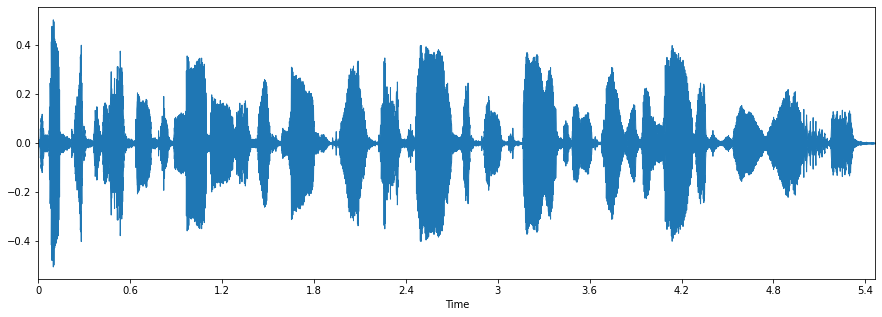

In [61]:
import librosa.display
import matplotlib.pyplot as plt

text = "Text To Speech models have made great strides in quality over the last few years."

# Generate raw waveform speech
speech, rate = tts(text), 22050

# Print waveplot
plt.figure(figsize=(15, 5))
plot = librosa.display.waveshow(speech, sr=rate)

The graph shows a plot of the audio. It clearly shows pauses between words and sentences as we would expect in spoken language. Now let's play the generated speech.

In [62]:
from IPython.display import Audio, display

import os

import soundfile as sf

def play(speech):
  # Convert to MP3 to save space
  sf.write("speech.wav", speech, 22050)
  !ffmpeg -i speech.wav -y -b:a 64 speech.mp3 2> /dev/null

  # Play speech
  display(Audio(filename="speech.mp3"))

play(speech)

# Transcribe audio back to text

Next we'll use [OpenAI Whisper](https://github.com/openai/whisper) to transcribe the generated audio back to text.

In [56]:
from txtai.pipeline import Transcription

# Transcribe files
transcribe = Transcription("openai/whisper-base")

# Print result
transcribe(speech, rate)

'Text to speech models have made great strides in quality over the last few years.'

And as expected, the transcription matches the original text.

# Audio books

The TextToSpeech pipeline is designed to work with large blocks of text. It could be used to build audio for entire chapters of books.

In the next example below, we'll read the beginning of the book the `Great Gatsby`.

In [57]:
# Beginning of The Great Gatsby from Project Gutenberg
# https://www.gutenberg.org/ebooks/64317

text = """
In my younger and more vulnerable years my father gave me some advice
that I've been turning over in my mind ever since.

“Whenever you feel like criticizing anyone,” he told me, “just
remember that all the people in this world haven't had the advantages
that you've had.”

He didn't say any more, but we've always been unusually communicative
in a reserved way, and I understood that he meant a great deal more
than that.
"""

speech = tts(text)
play(speech)

# Text To Speech Workflow

In the last example, we'll cover building a text-to-speech workflow. This workflow is no different in that it connects multiple pipelines together, each of which are backed by machine learning models. 

The workflow extracts text from a webpage, summarizes it and then generates audio of the summary.

In [49]:
%%writefile workflow.yml
summary:
  path: sshleifer/distilbart-cnn-12-6

textractor:
  join: true
  lines: false
  minlength: 100
  paragraphs: true
  sentences: false

texttospeech:

workflow:
  tts:
    tasks:
    - action: textractor
      task: url
    - action: summary
    - action: texttospeech

Overwriting workflow.yml


In [58]:
from txtai.app import Application

app = Application("workflow.yml")

speech = list(app.workflow("tts", ["https://en.wikipedia.org/wiki/Natural_language_processing"]))[0]

play(speech)

# Wrapping up

This notebook gave a brief introduction on text to speech models. The text to speech pipeline in txtai is designed to be easy to use and handles the most common text to speech tasks in English.  

This work is made possible by the excellent advancements in text to speech modeling. [ESPnet](https://github.com/espnet/espnet) is a great project and should be checked out for more advanced and a wider range of use cases. This pipeline was also made possible by the great work from [espnet_onnx](https://github.com/espnet/espnet_onnx) in building a framework to export models to ONNX.

Looking forward to seeing what the community dreams up using this pipeline!

